# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import random
import copy
import torch
from ddpg_agent import Agent, load_and_test


cpu


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.09000000171363354
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

state_size = env_info.vector_observations.shape[1]
agents_nb = len(env_info.agents)
action_size = brain.vector_action_space_size

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

Number of agents: 2


In [7]:

def ddpg(
    agent,
    n_episodes=2000,
    max_t=1500,
    print_every=100,
    gamma = 0.96,
    gamma_final = 0.99,
    gamma_rate = 0.02,
    tau = 0.008,
    tau_final = 0.001,
    tau_rate = 0.001,
    noise_scale = 1.0
    ):
    
    
    completed = False
    
    max_scores_deque = deque(maxlen = print_every)
    #scores_deque = deque(maxlen=print_every)
    #scores = []
    max_scores = []
    avg_max_scores = []
    best_avg_max = 0.0
    best_agent_max = 0.0
    for i_episode in range(1, n_episodes+1):
        
        # Reset environment
        env_info = env.reset(train_mode=True)[brain_name]
        
        # Get next state
        state = env_info.vector_observations
        
        # state = env.reset()
        agent.reset()

        score = np.zeros(agent.num_agents)
        
        for t in range(max_t):
            
            # Get actions
            action = agent.act(state, noise_scale)
            #print(action)

            # Send actions to the environment
            env_info = env.step(action)[brain_name]
            
            # Get next state
            next_state = env_info.vector_observations
            
            # Get rewards
            reward = env_info.rewards
            
            # Check if episode is finished
            done = env_info.local_done
            
            # Make the agent proceed to the next timestep in the environment
            agent.step(state, action, reward, next_state, done, gamma, tau)
            
            # Add rewards to scores
            score += reward
            
            # Replace the current state with the next state for the next episode
            state = next_state
            
            # Exit if episode is finished
            if np.any(done):
                break
                
        #print('Total score (averaged over agents) this episode: {}'.format(np.mean(score)))
        agent_avg = np.mean(score)
        agent_max = np.max(score)
        agent_min = np.min(score)
        max_scores.append(agent_max)
        max_scores_deque.append(agent_max)         
        avg_max = np.mean(max_scores_deque)
        avg_max_scores.append(avg_max)
        #scores_deque.append(agent_avg)
        #scores.append(agent_avg)
        avg_score = np.mean(max_scores_deque)
                          
        
        if i_episode % print_every == 0:
            print('Episode {}\t\t\t AvgMax: {:.4f}'.format(i_episode, avg_max))
        
        if i_episode >=100 and not completed and avg_max > 0.5:
            completed = True
            best_avg_max = avg_max
            torch.save(agent.actor_local.state_dict(), 'actor_weights.pth')
            torch.save(agent.critic_local.state_dict(), 'critic_weights.pth')
            print("100-episode-average max score >0.5 after {:d} episodes.\t AvgMax: {:.4f}".format(i_episode, avg_max))
        
        if completed and avg_max > best_avg_max:
            best_avg_max = avg_max
            torch.save(agent.actor_local.state_dict(), 'actor_weights_best_avg_max.pth')
            torch.save(agent.critic_local.state_dict(), 'critic_weights_best_avg_max.pth')
            print("New best 100-episode-average at Episode {:d}.\t AvgMax: {:.4f}".format(i_episode, avg_max))
        
               
        # Increase gamma discount factor. Limit to gamma_final.
        gamma = gamma_final - (1 - gamma_rate) * (gamma_final - gamma)
        
        tau = tau_final - (1 - tau_rate) * (tau_final - tau)
        
        
    torch.save(agent.actor_local.state_dict(), 'actor_final_weights.pth')
    torch.save(agent.critic_local.state_dict(), 'critic_final_weights.pth')
    return max_scores, avg_max_scores

In [8]:
agent = Agent(
    state_size = state_size,
    action_size = action_size,
    num_agents = num_agents,
    random_seed = 0,
    buffer_size = int(1e6),
    batch_size = 512, 
    lr_actor = 1e-3,
    lr_critic = 2e-3,
    noise_theta = 0.12,
    noise_sigma = 0.07,
    actor_fc1 = 164,
    actor_fc2 = 100,
    critic_fc1 = 164,
    critic_fc2 = 100,
    update_every = 15,
    num_updates = 12)

In [9]:

max_scores, avg_max_scores = ddpg(
    agent,
    n_episodes = 2000,
    max_t = 1000,
    gamma = 0.95,
    gamma_final = 0.99,
    gamma_rate = 0.02,
    tau = 0.008,
    tau_final = 0.001,
    tau_rate = 0.002,
    noise_scale = 1
)

Episode 100			 AvgMax: 0.0029
Episode 200			 AvgMax: 0.0040
Episode 300			 AvgMax: 0.0057
Episode 400			 AvgMax: 0.0115
Episode 500			 AvgMax: 0.0464
Episode 600			 AvgMax: 0.1322
Episode 700			 AvgMax: 0.4164
100-episode-average max score >0.5 after 707 episodes.	 AvgMax: 0.5154
New best 100-episode-average at Episode 708.	 AvgMax: 0.5334
New best 100-episode-average at Episode 709.	 AvgMax: 0.5514
New best 100-episode-average at Episode 710.	 AvgMax: 0.5613
New best 100-episode-average at Episode 712.	 AvgMax: 0.5783
New best 100-episode-average at Episode 713.	 AvgMax: 0.5873
New best 100-episode-average at Episode 714.	 AvgMax: 0.5894
New best 100-episode-average at Episode 715.	 AvgMax: 0.5913
New best 100-episode-average at Episode 750.	 AvgMax: 0.6071
New best 100-episode-average at Episode 751.	 AvgMax: 0.6141
New best 100-episode-average at Episode 753.	 AvgMax: 0.6181
New best 100-episode-average at Episode 754.	 AvgMax: 0.6381
New best 100-episode-average at Episode 759.	 Av

New best 100-episode-average at Episode 1877.	 AvgMax: 2.0138
New best 100-episode-average at Episode 1879.	 AvgMax: 2.0268
New best 100-episode-average at Episode 1884.	 AvgMax: 2.0337
New best 100-episode-average at Episode 1886.	 AvgMax: 2.0437
New best 100-episode-average at Episode 1887.	 AvgMax: 2.0557
New best 100-episode-average at Episode 1888.	 AvgMax: 2.0577
New best 100-episode-average at Episode 1890.	 AvgMax: 2.0827
Episode 1900			 AvgMax: 1.9337
Episode 2000			 AvgMax: 1.2884


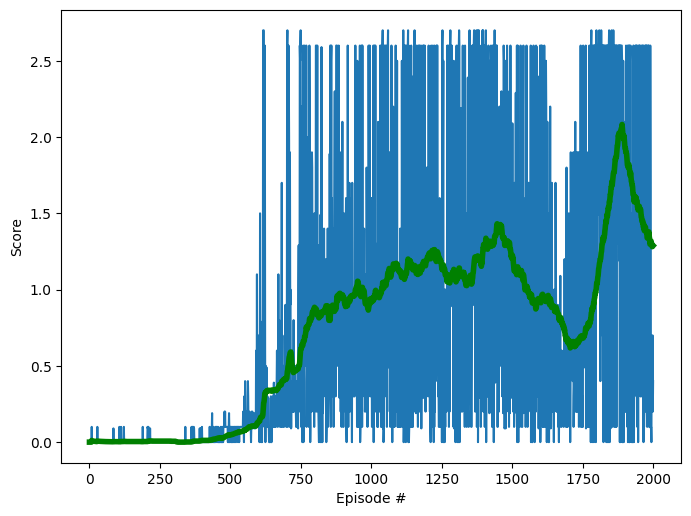

In [10]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(8, 6), dpi=100)

plt.plot(np.arange(1, len(max_scores)+1), max_scores)
plt.plot(np.arange(1, len(max_scores)+1), avg_max_scores, 'g',linewidth=4, label='avg')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [11]:
env.close()